In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# 标签格式要求:label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [5]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    print(y_true.get_label())
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # y_true.get_label().shape=(2025, )
    # y_pred.shape=(2025 *7, )
    # reshape_y_pred.shape=(2025, 7)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [6]:
evals_result = {}  # 储存评估指标(内置和自定义)结果
re_func = lgb.record_evaluation(eval_result=evals_result)
es_func = lgb.early_stopping(stopping_rounds=200)
le_func = lgb.log_evaluation(100)

params = {"objective": "multiclass",
          "num_class": 7,
          "max_depth": 3,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]

model = lgb.train(params=params,
                  train_set=train_dataset,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  callbacks=[re_func, es_func, le_func],
                  num_boost_round=200,  # 默认num_boost_round=1000
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

[4. 4. 0. ... 1. 4. 1.]
[4. 1. 1. 1. 5. 4. 2. 5. 0. 0. 4. 4. 1. 0. 1. 6. 3. 0. 5. 2. 5. 4. 3. 0.
 5. 1. 4. 4. 4. 0. 6. 1. 4. 4. 1. 4. 4. 4. 5. 6. 5. 4. 1. 1. 1. 1. 4. 0.
 3. 1. 1. 5. 3. 3. 4. 4. 1. 4. 4. 0. 1. 1. 4. 5. 6. 1. 5. 1. 1. 2. 4. 5.
 2. 0. 5. 4. 4. 4. 1. 0. 1. 5. 0. 1. 4. 0. 4. 4. 5. 4. 4. 1. 2. 4. 1. 1.
 0. 0. 4. 4. 5. 4. 5. 2. 4. 1. 1. 0. 5. 1. 1. 4. 4. 4. 4. 4. 5. 4. 2. 1.
 5. 4. 3. 1. 4. 1. 4. 4. 4. 5. 1. 1. 1. 6. 5. 1. 4. 1. 1. 1. 0. 1. 4. 5.
 4. 1. 5. 4. 1. 0. 1. 5. 0. 5. 0. 2. 1. 1. 4. 3. 6. 4. 0. 1. 1. 1. 0. 1.
 3. 1. 0. 1. 4. 4. 4. 2. 1. 0. 6. 4. 1. 3. 4. 5. 4. 1. 6. 5. 4. 1. 4. 1.
 0. 4. 0. 0. 1. 3. 2. 2. 0. 0. 0. 3. 5. 4. 5. 2. 1. 4. 0. 0. 4. 4. 2. 4.
 1. 5. 4. 4. 6. 1. 4. 1. 6. 2. 4. 2. 2. 0. 5. 3. 4. 1. 1. 1. 0. 5. 2. 4.
 1. 0. 0. 4. 4. 1. 0. 4. 1. 1. 2. 2. 0. 5. 0. 2. 1. 6. 5. 4. 1. 6. 1. 3.
 3. 1. 4. 1. 4. 6. 1. 2. 1. 4. 0. 4. 3. 4. 5. 0. 1. 4. 5. 2. 0. 4. 2. 4.
 1. 1. 2. 2. 0. 0. 0. 1. 1. 5. 0. 1. 1. 1. 1. 1. 2. 4. 1. 1. 0. 1. 1. 5.
 3. 3. 1. 4. 0. 1. 5. 4. 1.

array([[7.91678414e-05, 1.10751556e-02, 1.48197011e-05, ...,
        9.88662583e-01, 1.59224478e-04, 2.15118473e-08],
       [1.24035380e-01, 3.32927499e-01, 4.27651134e-04, ...,
        5.35664329e-01, 6.94039522e-03, 4.58807319e-06],
       [7.85252028e-01, 2.14694110e-01, 2.91688350e-06, ...,
        2.28965970e-05, 2.74063820e-05, 6.27477484e-07],
       ...,
       [7.96902838e-05, 3.79502407e-03, 2.51523441e-05, ...,
        9.95818459e-01, 2.42853425e-04, 3.61311494e-08],
       [4.00535692e-05, 5.19740453e-03, 3.77344334e-05, ...,
        9.94642971e-01, 8.13584163e-05, 3.91365543e-07],
       [3.59598301e-04, 8.79965044e-02, 2.25625186e-05, ...,
        9.11598201e-01, 2.12789344e-05, 1.69845661e-06]])

In [7]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.11921153362878699),
                          ('MY_GBM_LOSS', 0.119211533628787)]),
             'valid_1': OrderedDict([('multi_logloss', 0.373813767396771),
                          ('MY_GBM_LOSS', 0.3738137673967711)])})

In [8]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.4383695739657671,
                1.288001384118565,
                1.1753201011891665,
                1.0879127353563522,
                1.0182328508984893,
                0.9590282226737359,
                0.9075283759431337,
                0.8576768304673894,
                0.8176650781683008,
                0.7786892562316042,
                0.7484094044838275,
                0.7206466729131031,
                0.6957858174137684,
                0.674470754543991,
                0.6521903433087199,
                0.6319103146528672,
                0.6160780383056016,
                0.5994495499953746,
                0.5834727635630541,
                0.5693546792982175,
                0.5581846610151292,
                0.5464406165321637,
                0.5349938994228548,
                0.5244694160330217,
                0.5133933657302165,
                0.5052339104331122,
                0.4961

In [9]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

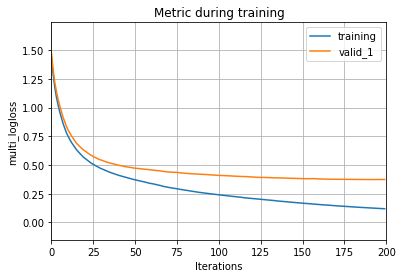

In [10]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

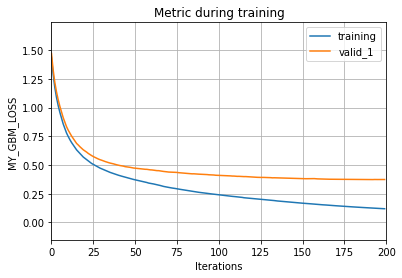

In [11]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [12]:
# 特征的相对重要性
model.feature_importance()

array([1543,  574,  266,  656,  573, 1109,  515,  604,  452, 1130,  123,
          0,   34,   67,   54,   62,    0,    0,   25,    0,    0,    0,
          0,   33,    0,   73,   21,    0,    0,    0,   49,    6,   16,
         63,    0,   12,   40,   27,    0,    0,    0,    0,   46,   72,
         17,   12,   26,    0,    0,    0,    0,   29,   21,    0])

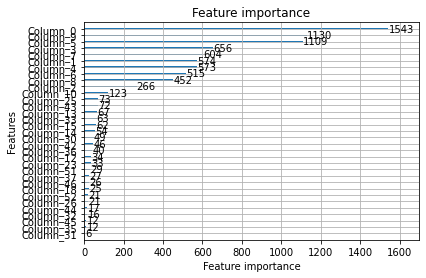

In [13]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

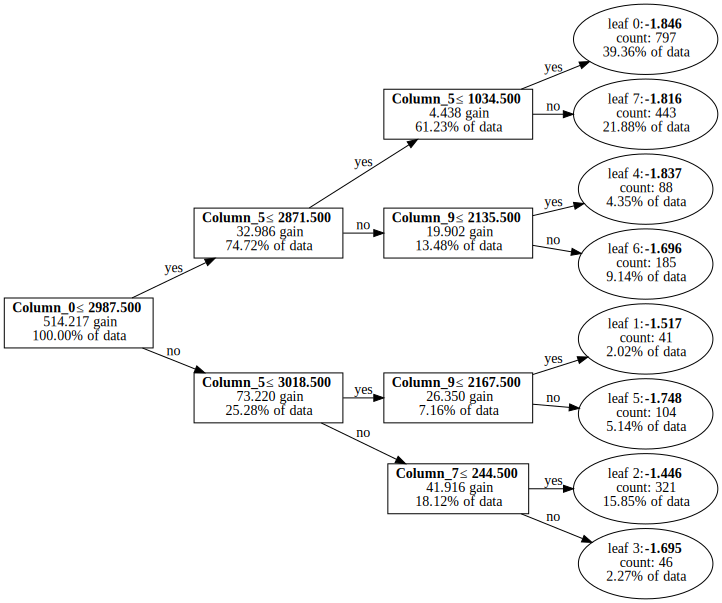

In [25]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model, show_info=['split_gain', 'leaf_count', 'data_percentage'])
img

In [15]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.graphs.Digraph

In [16]:
# 图保存
# 可对img_view.gv中的数据进行解析
img.view(filename="img_view.gv")

'img_view.gv.pdf'

In [17]:
'''
The returned DataFrame has the following columns.
    - ``tree_index`` : int64, which tree a node belongs to. 0-based, so a value of ``6``, for example, means "this node is in the 7th tree".
    - ``node_depth`` : int64, how far a node is from the root of the tree. The root node has a value of ``1``, its direct children are ``2``, etc.
    - ``node_index`` : str, unique identifier for a node.
    - ``left_child`` : str, ``node_index`` of the child node to the left of a split. ``None`` for leaf nodes.
    - ``right_child`` : str, ``node_index`` of the child node to the right of a split. ``None`` for leaf nodes.
    - ``parent_index`` : str, ``node_index`` of this node's parent. ``None`` for the root node.
    - ``split_feature`` : str, name of the feature used for splitting. ``None`` for leaf nodes.
    - ``split_gain`` : float64, gain from adding this split to the tree. ``NaN`` for leaf nodes.
    - ``threshold`` : float64, value of the feature used to decide which side of the split a record will go down. ``NaN`` for leaf nodes.
    - ``decision_type`` : str, logical operator describing how to compare a value to ``threshold``.
        For example, ``split_feature = "Column_10", threshold = 15, decision_type = "<="`` means that
        records where ``Column_10 <= 15`` follow the left side of the split, otherwise follows the right side of the split. ``None`` for leaf nodes.
    - ``missing_direction`` : str, split direction that missing values should go to. ``None`` for leaf nodes.
    - ``missing_type`` : str, describes what types of values are treated as missing.
    - ``value`` : float64, predicted value for this leaf node, multiplied by the learning rate.
    - ``weight`` : float64 or int64, sum of hessian (second-order derivative of objective), summed over observations that fall in this node.
    - ``count`` : int64, number of records in the training data that fall into this node.
'''
df = model.trees_to_dataframe()
df.head()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,Column_0,514.21698,2987.5,<=,left,None,-1.746860,0.000000,2025
1,0,2,0-S3,0-S6,0-S5,0-S0,Column_5,32.98650,2871.5,<=,left,None,-1.818390,254.066000,1513
2,0,3,0-S6,0-L0,0-L7,0-S3,Column_5,4.43850,1034.5,<=,left,None,-1.835300,208.223000,1240
3,0,4,0-L0,None,None,0-S6,None,NaN,NaN,None,None,None,-1.846184,133.833874,797
4,0,4,0-L7,None,None,0-S6,None,NaN,NaN,None,None,None,-1.815716,74.389468,443


In [18]:
# 决策路径
df[df['tree_index'] == 0]

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S3,0-S1,None,Column_0,514.216980,2987.5,<=,left,None,-1.746860,0.000000,2025
1,0,2,0-S3,0-S6,0-S5,0-S0,Column_5,32.986500,2871.5,<=,left,None,-1.818390,254.066000,1513
2,0,3,0-S6,0-L0,0-L7,0-S3,Column_5,4.438500,1034.5,<=,left,None,-1.835300,208.223000,1240
3,0,4,0-L0,None,None,0-S6,None,NaN,NaN,None,None,None,-1.846184,133.833874,797
4,0,4,0-L7,None,None,0-S6,None,NaN,NaN,None,None,None,-1.815716,74.389468,443
5,0,3,0-S5,0-L4,0-L6,0-S3,Column_9,19.902100,2135.5,<=,left,None,-1.741600,45.842700,273
6,0,4,0-L4,None,None,0-S5,None,NaN,NaN,None,None,None,-1.837133,14.777140,88
7,0,4,0-L6,None,None,0-S5,None,NaN,NaN,None,None,None,-1.696156,31.065579,185
8,0,2,0-S1,0-S4,0-S2,0-S0,Column_5,73.220497,3018.5,<=,left,None,-1.535460,85.976100,512
9,0,3,0-S4,0-L1,0-L5,0-S1,Column_9,26.349800,2167.5,<=,left,None,-1.682280,24.348700,145
